In [8]:
%matplotlib notebook
from pylab import *
import pandas as pd
from sklearn.decomposition import PCA

In [9]:
def sort_lidar_file_and_shape(file_name, width=2088, height=64):
    df = pd.read_csv(file_name,
                     names = ['x', 'y', 'z', 'intensity', 'ring', 'rotation', 'revolution'])
    df.sort_values(['rotation', 'ring'], inplace = True)
    img = np.zeros((width, height, 3))
    for i in range(width):
        df_rot_slice = df.iloc[height * i : height * (i + 1)]
        img[i] = df_rot_slice.as_matrix()[:, :3]
    
    lidar_readings = np.rot90(img)
    return lidar_readings

In [10]:
readings_file_name = "1504892561136210918-cloudpoint.csv"

lidar_table = sort_lidar_file_and_shape(readings_file_name)

width = 2088
height = 64 
lidar = lidar_table.reshape((width * height, 3))

In [17]:
neighbor_side = 6
neighbor_side_half = neighbor_side // 2

model = PCA()
normals = np.zeros(lidar_table.shape)
depths = np.linalg.norm(lidar_table, axis=-1)

for i in range(neighbor_side_half, height-neighbor_side_half):
    for j in range(0, width):        
        neighbor_y_start = i - neighbor_side_half
        neighbor_y_end = i + neighbor_side_half
        neighbor_x = np.arange(j - neighbor_side_half, j + neighbor_side_half)
        
        neighbors = lidar_table[neighbor_y_start:neighbor_y_end]
        neighbors = np.take(neighbors, neighbor_x, axis = 1, mode='wrap')
        
        neighbor_depths = depths[neighbor_y_start:neighbor_y_end]
        neighbor_depths = np.take(neighbor_depths, neighbor_x, axis=1, mode='wrap')
        
        neighbors = neighbors.reshape((neighbor_side * neighbor_side, 3))
        neighbor_depths = neighbor_depths.ravel()
        
        valid_neighbors = neighbors[(neighbor_depths - depths[i, j]) <= 0.5]
        model.fit(valid_neighbors)
        if model.components_.shape == (3, 3):
            normals[i, j] = model.components_[:, 2]

/Users/garychen/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/pca.py:398: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


In [19]:
#dists = np.linalg.norm(lidar, axis=-1)
#inds = np.where(dists < 10)
normals = normals.reshape((normals.shape[0] * normals.shape[1], 3))

inds = np.arange(len(lidar))
 
lidar_center = lidar[inds]
normals_center = normals[inds]

green = np.array([0, 1, 0])
red = np.array([1, 0, 0])
blue = np.array([0, 0, 1])

ValueError: cannot reshape array of size 400896 into shape (400896,3)

In [41]:
order = np.zeros((height, width, 3))
half_width = width / 2
for i in range(width):
    for j in range(height):
        x = i
        if x >= half_width:
            x = width - i
        rgval = x / half_width
        bval = j / height
        order[j, i] = rgval * red + (1 - rgval) * green + bval * blue

order = order.reshape((width * height, 3))

order_center = order[inds]

In [21]:
lidar_file_name = "lidar_test.csv"

with open(lidar_file_name, 'w') as f:
    for rd in lidar_center:
        f.write("{}, {}, {}\n".format(rd[0], rd[1], rd[2]))

In [20]:
normal_file_name = "normal_colors_test.csv"

with open(normal_file_name, 'w') as f:
    temp = normals_center / 2.0 + 0.5
    for rd in temp:
        f.write("{}, {}, {}\n".format(rd[0], rd[1], rd[2]))

In [44]:
with open("width_order_colors_test.csv", 'w') as f:
    for rd in order_center:
        f.write("{}, {}, {}\n".format(rd[0], rd[1], rd[2]))

<IPython.core.display.Javascript object>


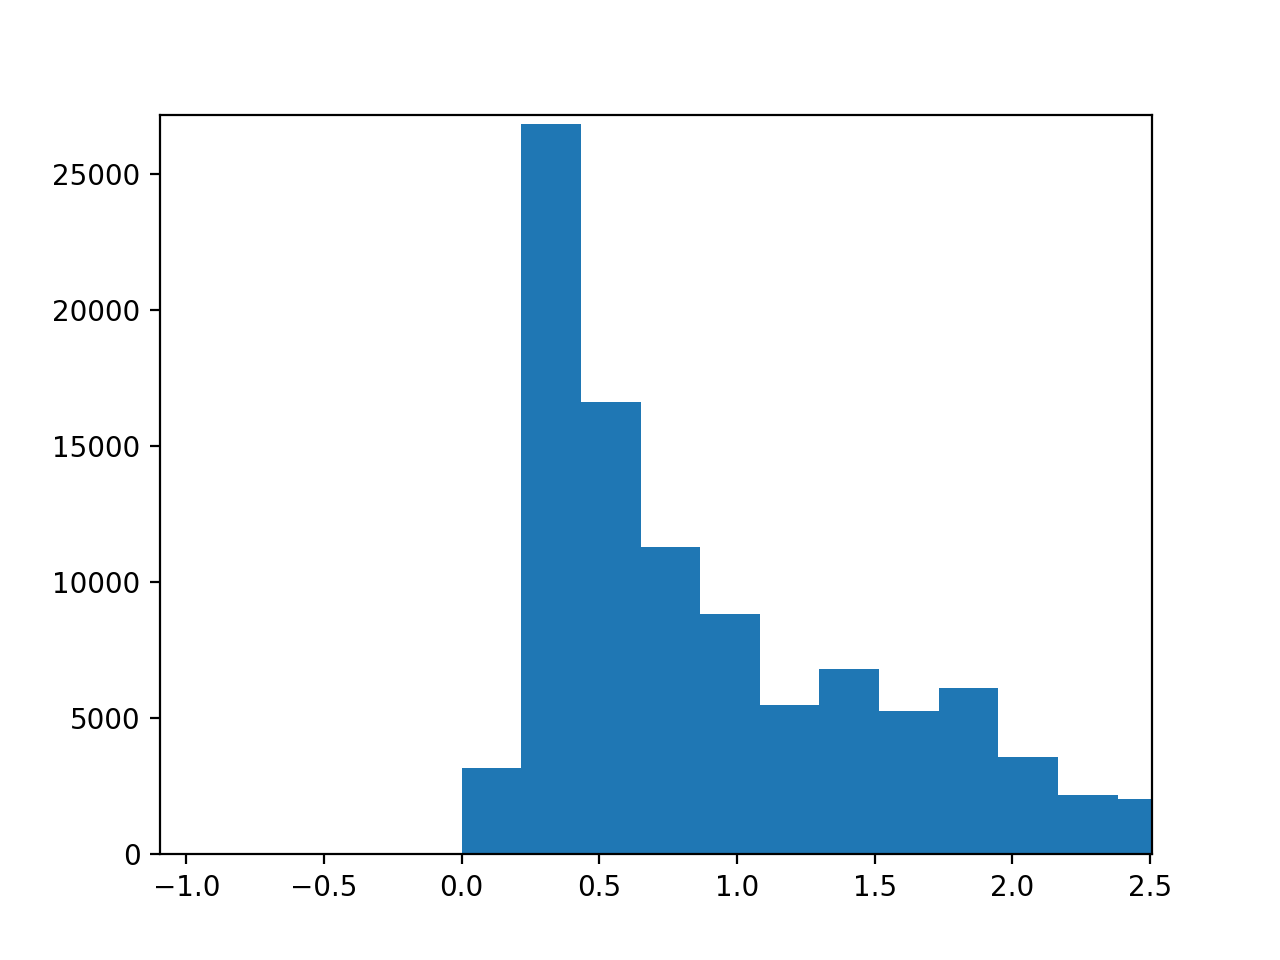

In [15]:
plt.hist(np.linalg.norm(up_vectors.reshape((height * width, 3)), axis=-1), bins=500)
plt.show()

In [51]:
# up_vectors = lidar_table[:lidar_table.shape[0] - 1] - lidar_table[1:]
# left_vectors = np.zeros(up_vectors.shape)
# left_vectors[:, 1:] = lidar_table[1:, :lidar_table.shape[1] - 1] - lidar_table[1:, 1:]
# left_vectors[:, 0] = lidar_table[1:, lidar_table.shape[1] - 1] - lidar_table[1:, 0]
# normals = np.cross(up_vectors, left_vectors)

# zero_arr = np.array([0, 0, 0])

# for i in range(1, height):
#     for j in range(0, width):

#         leftj = j - 1
#         if j < 0:
#             j = width - 1
#         if np.linalg.norm(lidar_table[i, j] - lidar_table[i - 1, j]) > 0.5:
#             normals[i - 1, j] = zero_arr
#         elif np.linalg.norm(lidar_table[i, leftj] - lidar_table[i, leftj]) > 0.5:
#             normals[i - 1, j] = zero_arr

# averaged_normals = np.zeros(normals.shape)

# for i in range(0, height - 1):
#     for j in range(0, width):
#         center_normal = normals[i, j]
#         avg_normal = np.zeros(3)
#         count = 0
#         for di in range(-1, 2):
#             for dj in range(-1, 2):
#                 new_i = i + di
#                 new_j = j + dj
#                 if new_i >= 0 and new_j >= 0 and new_i < height - 1 and new_j < width:
#                     if np.linalg.norm(lidar_table[i + 1, j] - lidar_table[new_i + 1, new_j]) < 0.5:
#                         adjacent_normal = normals[new_i, new_j]
#                         if not np.array_equal(adjacent_normal, zero_arr):
#                             avg_normal += adjacent_normal
#                             count += 1
#         if count != 0:
#             averaged_normals[i, j] = avg_normal / count
#             averaged_normals[i, j] /= np.linalg.norm(averaged_normals[i, j])

# normals = averaged_normals.reshape((width * (height - 1), 3))  
# #normals = up_vectors.reshape((width * (height - 1), 3))
